#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

In [2]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [4]:
from data_loader import makeTensorLoaders

#### Test for CUDA

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Simulation parameters

In [6]:
N = 128 ## number of recurrent neurons
nsecs = 50 ## time
n_channels = 1

In [7]:
nRuns = 5

#### Train and test datasets

In [8]:
def random_assignment(numSamps, n, p):
    # Create a zero array of shape (numSamps, n)
    arr = np.random.choice([-1, 1], size=(numSamps, n))
    
    # Randomly assign 1 or -1 to elements with probability p
    rand_arr = np.random.random(arr.shape)
    arr[np.random.random(arr.shape) > p] = 0
    
    return arr

In [9]:
nTrain = 6000
nTest = 1000
prob_delta = 0.05

In [10]:
batch_size = 200

In [11]:
def flipflop_output(input_array):
    output_array = np.zeros_like(input_array)
    current_state = 0  # Track the current state
    
    for tt in range(len(input_array)):
        if input_array[tt] !=0:
            current_state = input_array[tt]
            output_array[tt:] = current_state
            
    return output_array

In [12]:
data_in_train = {}
data_in_test = {}

In [13]:
data_out_train = {}
data_out_test = {}

In [14]:
for cntr in range(nRuns):
    data_in_train[cntr] = random_assignment(nTrain, nsecs, prob_delta)
    data_in_test[cntr] = random_assignment(nTest, nsecs, prob_delta)
    
    data_out_train[cntr] = np.zeros_like(data_in_train[cntr])
    data_out_test[cntr] = np.zeros_like(data_in_test[cntr])
    
    for ii in range(nTrain):
        data_out_train[cntr][ii] = flipflop_output(data_in_train[cntr][ii])
        
    for ii in range(nTest):
        data_out_test[cntr][ii] = flipflop_output(data_in_test[cntr][ii])

In [15]:
train_loader = {}
test_loader = {}

In [16]:
for cntr in range(nRuns):
    train_loader[cntr] = makeTensorLoaders((data_in_train[cntr], data_out_train[cntr]), batch_size, shuffle=True)
    test_loader[cntr] = makeTensorLoaders((data_in_test[cntr], data_out_test[cntr]), batch_size, shuffle=False)

#### Model and other hyper-params

In [17]:
num_layers = 1
input_size = n_channels
hidden_size = N
output_size = input_size

In [18]:
def initialize_weights(N, index_ranges, signs):
    weights = np.zeros((N, N))
    for ii, (start, end) in enumerate(index_ranges):
        limit = 1 / np.sqrt(N) if signs[ii] == 1 else -1/np.sqrt(N)
        weights[:, start:end] = np.random.uniform(0, limit, size=(N, end-start))
    return weights

In [19]:
def generate_mask(weights, index_ranges, signs):
    mask = np.zeros_like(weights)
    for i, (start, end) in enumerate(index_ranges):
        if signs[i] == 1:
            mask[:, start:end] = np.where(weights[:, start:end] > 0, 1, 0)
        elif signs[i] == -1:
            mask[:, start:end] = np.where(weights[:, start:end] < 0, 1, 0)
    return mask

In [20]:
# Define the neural network
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device):
        
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_size = output_size
        self.device = device

    def forward(self, x):
        m = nn.Tanh()
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, nSteps, inDim = x.shape
        
        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)
        pred = torch.zeros(nSamp,nSteps,self.output_size, requires_grad=False).to(self.device)
        
        for ii in range(nSteps):
            ip = torch.unsqueeze(x[:,ii,:],1)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
#             fr_mask = ht.clone()>0
#             htt = fr_mask*ht.clone() ## mask firing rate
            h0 = ht ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred[:,ii,:] = m(self.fc(ops[:, ii, :].clone()))
        
        return pred, ht

In [21]:
frac_ex = 0.8
frac_in = 1-frac_ex

In [22]:
signs = [1,-1]
index_ranges = [(0,int(N*frac_ex)),(int(N*frac_ex),N)]

In [23]:
# Initialize the model
model = {}
weights_init = {}

In [24]:
for cntr in range(nRuns):
    model[cntr] = SimpleRNN(input_size, hidden_size, output_size, device).to(device)
    weights_init[cntr] = initialize_weights(N,index_ranges,signs)
    model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(weights_init[cntr]).float().to(device)

In [25]:
pp = 1.0
conn_mask = {}
sign_mask = {}
full_mask = {}

In [26]:
for cntr in range(nRuns):
    conn_mask[cntr] = np.random.choice([0, 1], size=(N,N), p=[1-pp, pp])
    sign_mask[cntr] = np.sign(weights_init[cntr])
    sign_mask[cntr][sign_mask[cntr] == 0] = 1
    full_mask[cntr] = torch.from_numpy(sign_mask[cntr]*conn_mask[cntr]).float().to(device)

Text(0.5, 1.0, 'Initial Weights: Conventional Backprop')

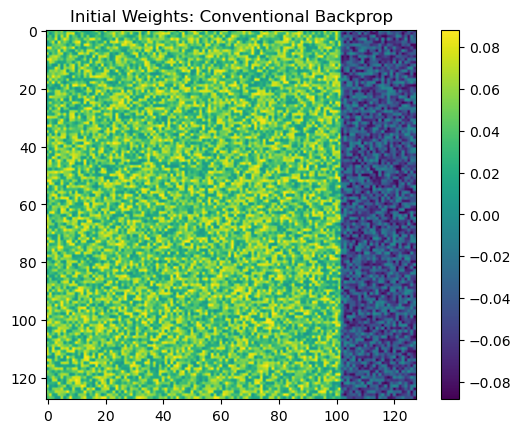

In [27]:
kk = 0

plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights: Conventional Backprop')

Text(0, 0.5, 'Counts')

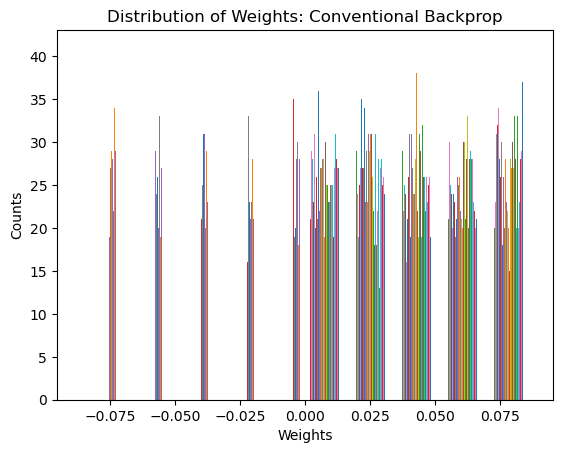

In [28]:
plt.hist(weights_init[kk])
plt.title('Distribution of Weights: Conventional Backprop')
plt.xlabel('Weights')
plt.ylabel('Counts')

#### Model training

In [29]:
num_epochs = 100
learning_rate = 0.001

In [30]:
criterion = nn.MSELoss()

optimizer = {}
for cntr in range(nRuns):
    optimizer[cntr] = optim.Adam(model[cntr].parameters(), lr=learning_rate)

In [31]:
train_losses = np.zeros((nRuns, num_epochs))
test_losses = np.zeros((nRuns, num_epochs))

In [32]:
for run in tqdm(range(nRuns)):
    model[run].train()
    train_loss_min = np.Inf
    
    for epoch in range(1, num_epochs+1):
        print('Epoch: ',epoch)

        train_loss = 0.0
        test_loss = 0.0
        
        for inputs, targets in train_loader[run]:
            if train_on_gpu:
                inputs, targets = torch.unsqueeze(inputs.float().cuda(),-1), torch.unsqueeze(targets.float().cuda(),-1)
                model[run].cuda()
            else:
                inputs, targets = torch.unsqueeze(inputs.float(),-1), torch.unsqueeze(targets.float(),-1)

            optimizer[run].zero_grad()
            outputs, firing_rates = model[run](inputs)
            if train_on_gpu:
                outputs = outputs.cuda()
            loss = criterion(outputs, targets)
            train_loss += loss.item()

            loss.backward()
            optimizer[run].step()

            ## Rectify weights
#             w = model[run].rnn.weight_hh_l0.detach().cpu().numpy()
#             w[w < 0] = 0
#             model[run].rnn.weight_hh_l0.data = torch.from_numpy(w).float().to(device)
            
            ## Apply mask
#             model[run].rnn.weight_hh_l0.data = full_mask[run]*model[run].rnn.weight_hh_l0.data

        if train_loss< train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            train_loss_min = train_loss
        
        train_losses[run][epoch-1] = train_loss

        for inputs_test, targets_test in test_loader[run]:
            if train_on_gpu:
                inputs_test, targets_test = torch.unsqueeze(inputs_test.float().cuda(),-1), torch.unsqueeze(targets_test.float().cuda(),-1)
                model[run].cuda()
            else:
                inputs_test, targets_test = torch.unsqueeze(inputs_test.float(),-1), torch.unsqueeze(targets_test.float(),-1)

            outputs_test, firing_rates_test = model[run](inputs_test)
            if train_on_gpu:
                outputs_test = outputs_test.cuda()
            loss_test = criterion(outputs_test, targets_test)
            test_loss += loss_test.item()
            
        test_losses[run][epoch-1] = test_loss

        print('Epoch: {}, Test Loss({:.6f})'.format(epoch,test_loss))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->20.369992)
Epoch: 1, Test Loss(3.243170)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (20.369992-->19.669825)
Epoch: 2, Test Loss(3.216419)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (19.669825-->19.624241)
Epoch: 3, Test Loss(3.207168)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (19.624241-->19.518619)
Epoch: 4, Test Loss(3.187663)
Epoch:  5
Epoch: 5, Test Loss(3.100162)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (19.518619-->19.494702)
Epoch: 6, Test Loss(3.181581)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (19.494702-->18.949084)
Epoch: 7, Test Loss(2.959121)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (18.949084-->17.913482)
Epoch: 8, Test Loss(2.822963)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (17.913482-->17.117382)
Epoch: 9, Test Loss(3.073046)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (17.117382-->15.860724)
Epoch: 10, Test Loss(5.383688)
Epoch:  11
Epoch: 11, Test Loss(3.218145)
Epoch:  12
Epoch: 12, Test Loss(3.107983)
Epoch:

 20%|██        | 1/5 [04:46<19:07, 286.75s/it]

Epoch: 100, Train Loss Decreased!! (0.065780-->0.063154)
Epoch: 100, Test Loss(0.010593)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->19.809623)
Epoch: 1, Test Loss(3.197590)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (19.809623-->19.478900)
Epoch: 2, Test Loss(3.305432)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (19.478900-->19.390260)
Epoch: 3, Test Loss(3.285234)
Epoch:  4
Epoch: 4, Test Loss(3.218145)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (19.390260-->19.364277)
Epoch: 5, Test Loss(3.171929)
Epoch:  6
Epoch: 6, Test Loss(3.973868)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (19.364277-->19.162916)
Epoch: 7, Test Loss(3.054482)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (19.162916-->18.164882)
Epoch: 8, Test Loss(2.978813)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (18.164882-->17.796949)
Epoch: 9, Test Loss(2.923803)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (17.796949-->17.388502)
Epoch: 10, Test Loss(2.822074)
Epoch:  11
Epoch: 11, Train Loss Decreased!! (17.388502-->

Epoch: 94, Test Loss(0.003661)
Epoch:  95
Epoch: 95, Test Loss(0.000998)
Epoch:  96
Epoch: 96, Test Loss(0.000936)
Epoch:  97
Epoch: 97, Train Loss Decreased!! (0.005976-->0.005483)
Epoch: 97, Test Loss(0.000888)
Epoch:  98
Epoch: 98, Train Loss Decreased!! (0.005483-->0.005241)
Epoch: 98, Test Loss(0.000847)
Epoch:  99
Epoch: 99, Train Loss Decreased!! (0.005241-->0.005028)
Epoch: 99, Test Loss(0.000815)
Epoch:  100
Epoch: 100, Train Loss Decreased!! (0.005028-->0.004837)


 40%|████      | 2/5 [09:32<14:18, 286.11s/it]

Epoch: 100, Test Loss(0.000783)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->19.616411)
Epoch: 1, Test Loss(3.219396)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (19.616411-->19.360186)
Epoch: 2, Test Loss(3.200395)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (19.360186-->19.334360)
Epoch: 3, Test Loss(3.192901)
Epoch:  4
Epoch: 4, Test Loss(3.195582)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (19.334360-->18.973334)
Epoch: 5, Test Loss(3.005587)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (18.973334-->18.679808)
Epoch: 6, Test Loss(2.924446)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (18.679808-->18.129066)
Epoch: 7, Test Loss(3.176460)
Epoch:  8
Epoch: 8, Test Loss(2.939589)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (18.129066-->16.700526)
Epoch: 9, Test Loss(2.378871)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (16.700526-->12.484406)
Epoch: 10, Test Loss(1.424902)
Epoch:  11
Epoch: 11, Test Loss(3.201815)
Epoch:  12
Epoch: 12, Test Loss(2.478725)
Epoch:  13
Epoch: 13, Train Los

 60%|██████    | 3/5 [14:18<09:32, 286.22s/it]

Epoch: 100, Train Loss Decreased!! (0.145811-->0.136894)
Epoch: 100, Test Loss(0.021691)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->20.263983)
Epoch: 1, Test Loss(3.195038)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (20.263983-->19.464389)
Epoch: 2, Test Loss(3.182260)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (19.464389-->19.437831)
Epoch: 3, Test Loss(3.183223)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (19.437831-->19.375426)
Epoch: 4, Test Loss(3.149547)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (19.375426-->19.249905)
Epoch: 5, Test Loss(3.147887)
Epoch:  6
Epoch: 6, Test Loss(3.253755)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (19.249905-->19.165921)
Epoch: 7, Test Loss(3.110366)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (19.165921-->18.909069)
Epoch: 8, Test Loss(3.058371)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (18.909069-->18.245442)
Epoch: 9, Test Loss(2.765498)
Epoch:  10
Epoch: 10, Test Loss(3.123555)
Epoch:  11
Epoch: 11, Test Loss(3.098739)
Epoch:  12
Epoch:

 80%|████████  | 4/5 [19:05<04:46, 286.54s/it]

Epoch: 100, Test Loss(0.017240)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->19.802998)
Epoch: 1, Test Loss(3.177009)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (19.802998-->19.569189)
Epoch: 2, Test Loss(3.196526)
Epoch:  3
Epoch: 3, Test Loss(3.146097)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (19.569189-->19.368491)
Epoch: 4, Test Loss(3.080246)
Epoch:  5
Epoch: 5, Test Loss(3.193630)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (19.368491-->19.222098)
Epoch: 6, Test Loss(3.052937)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (19.222098-->18.428862)
Epoch: 7, Test Loss(2.835994)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (18.428862-->17.824592)
Epoch: 8, Test Loss(2.871941)
Epoch:  9
Epoch: 9, Test Loss(2.908087)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (17.824592-->16.269197)
Epoch: 10, Test Loss(1.912134)
Epoch:  11
Epoch: 11, Train Loss Decreased!! (16.269197-->14.188369)
Epoch: 11, Test Loss(1.809120)
Epoch:  12
Epoch: 12, Test Loss(1.872347)
Epoch:  13
Epoch: 13, Test Los

100%|██████████| 5/5 [23:49<00:00, 285.95s/it]

Epoch: 100, Test Loss(0.003452)


In [33]:
outputs_np = outputs.detach().cpu().numpy()
targets_np = targets.detach().cpu().numpy()
firing_rates_np = firing_rates.detach().cpu().numpy()

In [34]:
outputs_test_np = outputs_test.detach().cpu().numpy()
targets_test_np = targets_test.detach().cpu().numpy()
firing_rates_test_np = firing_rates_test.detach().cpu().numpy()

Text(0.5, 1.0, 'Test')

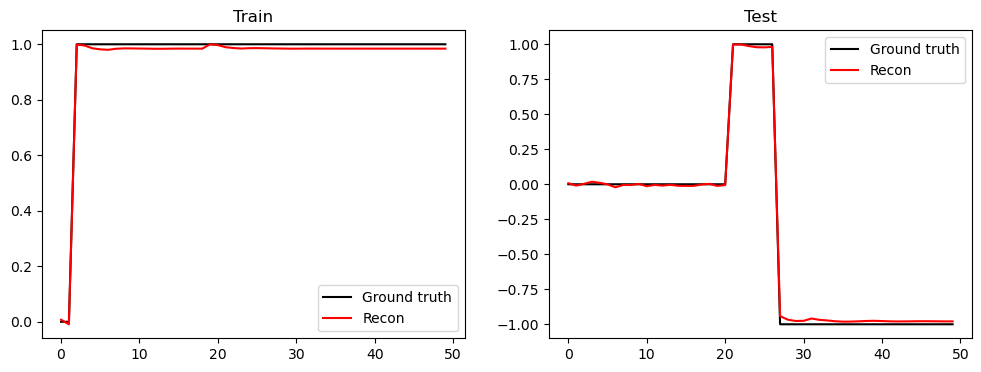

In [35]:
kk = 10 ## all zeros freaks it out

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(targets_np[kk],label='Ground truth',color='k')
plt.plot(outputs_np[kk],label='Recon',color='r')
plt.legend()
plt.title('Train')

plt.subplot(122)
plt.plot(targets_test_np[kk],label='Ground truth',color='k')
plt.plot(outputs_test_np[kk],label='Recon',color='r')
plt.legend()
plt.title('Test')

In [36]:
weights_final = {}
for cntr in range(nRuns):
    weights_final[cntr] = model[cntr].rnn.weight_hh_l0.detach().cpu().numpy()

Text(0.5, 1.0, 'Final Weights')

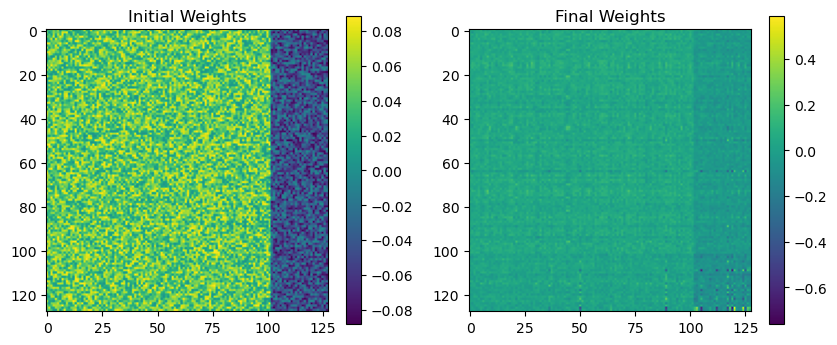

In [37]:
kk = 0

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights')

plt.subplot(122)
plt.imshow(weights_final[kk])
plt.colorbar()
plt.title('Final Weights')

Text(0, 0.5, 'Counts')

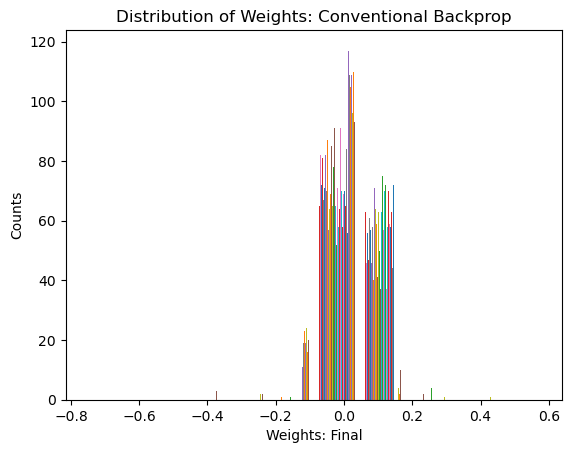

In [38]:
plt.hist(weights_final[kk])
plt.title('Distribution of Weights: Conventional Backprop')
plt.xlabel('Weights: Final')
plt.ylabel('Counts')

In [39]:
mean_train_losses = np.mean(train_losses, axis=0)
variance_train_losses = np.var(train_losses, axis=0)

mean_test_losses = np.mean(test_losses, axis=0)
variance_test_losses = np.var(test_losses, axis=0)

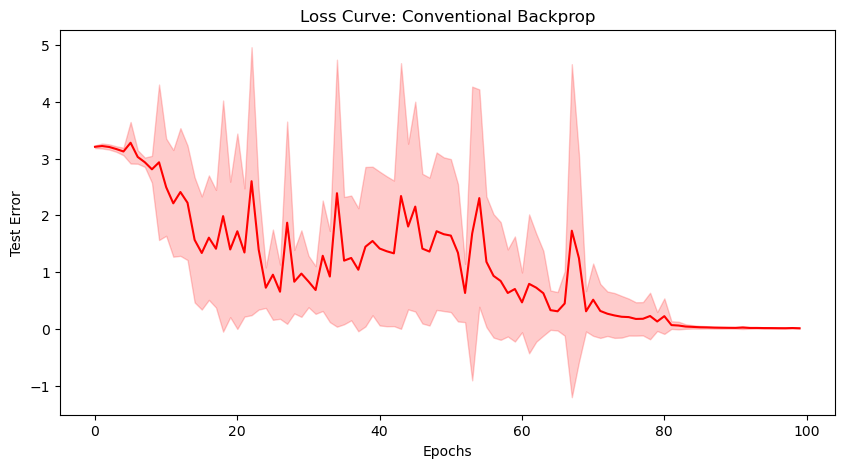

In [40]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
# sns.lineplot(x=x, y=mean_train_losses, color='r')
# plt.fill_between(x, mean_train_losses - np.sqrt(variance_train_losses), mean_train_losses + np.sqrt(variance_train_losses),
#                  color='r', alpha=0.2)

sns.lineplot(x=x, y=mean_test_losses, color='r')
plt.fill_between(x, mean_test_losses - np.sqrt(variance_test_losses), mean_test_losses + np.sqrt(variance_test_losses),
                 color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Error')
plt.title('Loss Curve: Conventional Backprop')

# Show plot
plt.show()

#### Saves

In [41]:
## Save train, test losses + accuracies
np.save('flipflop_train_losses_conventional_backprop',train_losses)
np.save('flipflop_test_losses_conventional_backprop',test_losses)

In [42]:
# Save dictionary to a Numpy .npz file
np.savez('flipflop_weights_init_conventional.npz', weights_init, pickle=True)
np.savez('flipflop_weights_final_conventional.npz', weights_final, pickle=True)